In [12]:
from glob import glob
import random

import numpy as np
import xarray as xr
import salem
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from python import wind_utils as wu
from python import utils as pu

## Bias-correction

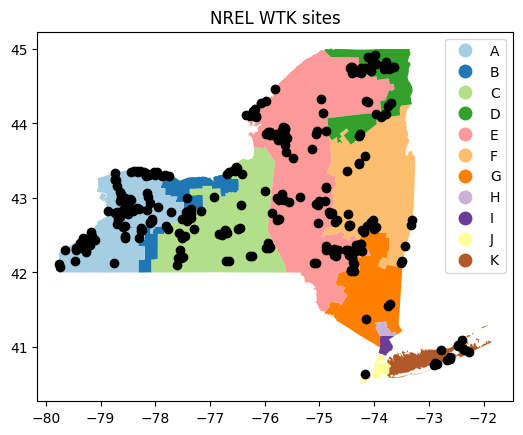

In [4]:
# Show WTK locations
df_wtk = wu.read_all_wtk(keep_every=10)
latlons = df_wtk[['wtk_lat', 'wtk_lon']].value_counts().index.unique()

# Load NYISO
nyiso_gdf = gpd.read_file(f"{pu.project_path}/data/nyiso/shapefiles/NYISO_Load_Zone_Dissolved.shp")

# Plot
fig, ax = plt.subplots()
nyiso_gdf.plot(column='ZONE', legend=True, cmap='Paired', ax=ax)
lats = latlons.get_level_values(0)
lons = latlons.get_level_values(1)
ax.scatter(lons, lats, color='black')
ax.set_title('NREL WTK sites')

plt.savefig('../../figs/nrel_wtk_sites_every10.png', dpi=300, bbox_inches='tight')

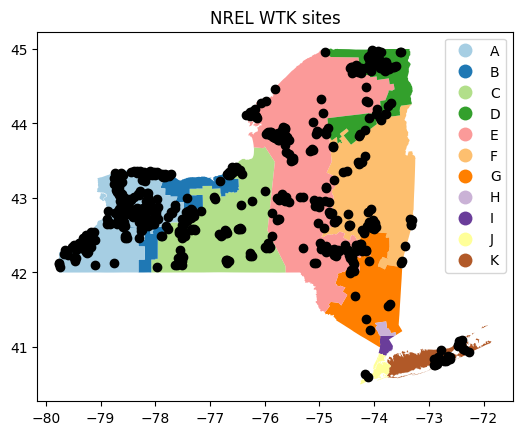

In [5]:
# Show WTK locations
df_wtk = wu.read_all_wtk(keep_every=5)
latlons = df_wtk[['wtk_lat', 'wtk_lon']].value_counts().index.unique()

# Load NYISO
nyiso_gdf = gpd.read_file(f"{pu.project_path}/data/nyiso/shapefiles/NYISO_Load_Zone_Dissolved.shp")

# Plot
fig, ax = plt.subplots()
nyiso_gdf.plot(column='ZONE', legend=True, cmap='Paired', ax=ax)
lats = latlons.get_level_values(0)
lons = latlons.get_level_values(1)
ax.scatter(lons, lats, color='black')
ax.set_title('NREL WTK sites')

plt.savefig('../../figs/nrel_wtk_sites_every5.png', dpi=300, bbox_inches='tight')

### Analysis

In [ ]:
%%time
# Get TGW input wind data
start_year = 2007
end_year = 2013
wtk_keep_every = 5

climate_paths = np.array([glob(f"{pu.tgw_path}/historical_1980_2019/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
                          for year in range(start_year, end_year+1)]).flatten()

df = wu.prepare_wind_data(
    climate_paths = climate_paths,
    wind_vars = ['U10', 'V10'],
    lat_name="south_north",
    lon_name="west_east",
    curvilinear=True,
    parallel=True,
    wtk_keep_every=5,
)

In [ ]:
start_year = 2007
end_year = 2013
wtk_keep_every = 5

In [ ]:
# Compute and store the stability coefficients
res = wu.get_stability_coefficients(df, 'ws', 'ws_wtk').reset_index()
res.to_csv(f"{pu.project_path}/data/wind/models/tgw_stability_coefficients_{start_year}-{end_year}_every{wtk_keep_every}.csv", index=False)

### Plots

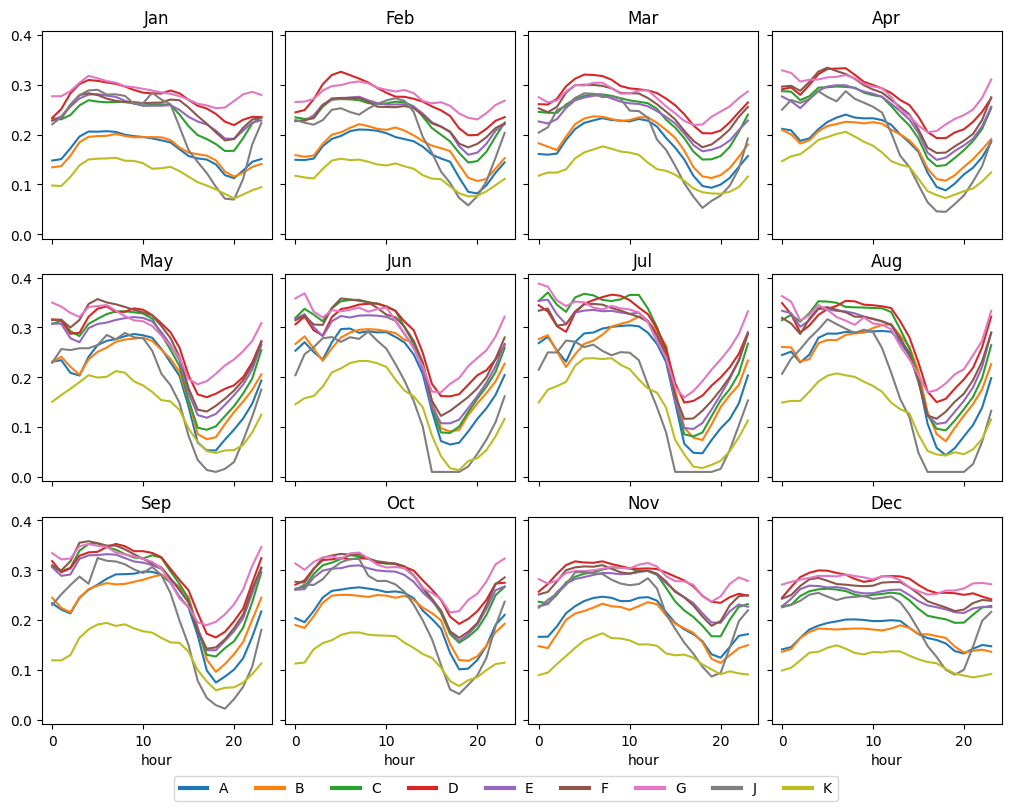

In [11]:
# Plot the stability coefficients
fig, axs = plt.subplots(3, 4, figsize=(10,8), layout='constrained', sharey=True, sharex=True)
axs = axs.flatten()

for month in range(1,13):
    ax = axs[month-1]
    for idz, zone in enumerate(res['ZONE'].unique()):
        res_sel = res[(res['month'] == month) & (res['ZONE'] == zone)]
        res_sel.plot(x='hour', y='alpha', color=f"C{idz}", legend=False, ax=ax)
    ax.set_title(pu.month_names[month-1])

# Add legend
handles = [Line2D([0], [0], color=f"C{idz}", label=zone, lw=3) for idz, zone in enumerate(res['ZONE'].unique())]
fig.legend(handles = handles,
          loc='outside lower center',
          ncol=len(handles))

plt.savefig('../../figs/wind_stability_coeffs.png', dpi=300, bbox_inches='tight')

In [17]:
# Merge and plot results
df = pd.merge(df, res, on =['hour', 'month', 'ZONE'])

# Calculate corrected windspeed
df['ws_corrected'] = df['ws'] * (100/10)**df['alpha']

# Get unique latlons
latlons = df[['wtk_lat', 'wtk_lon']].value_counts().index.unique()

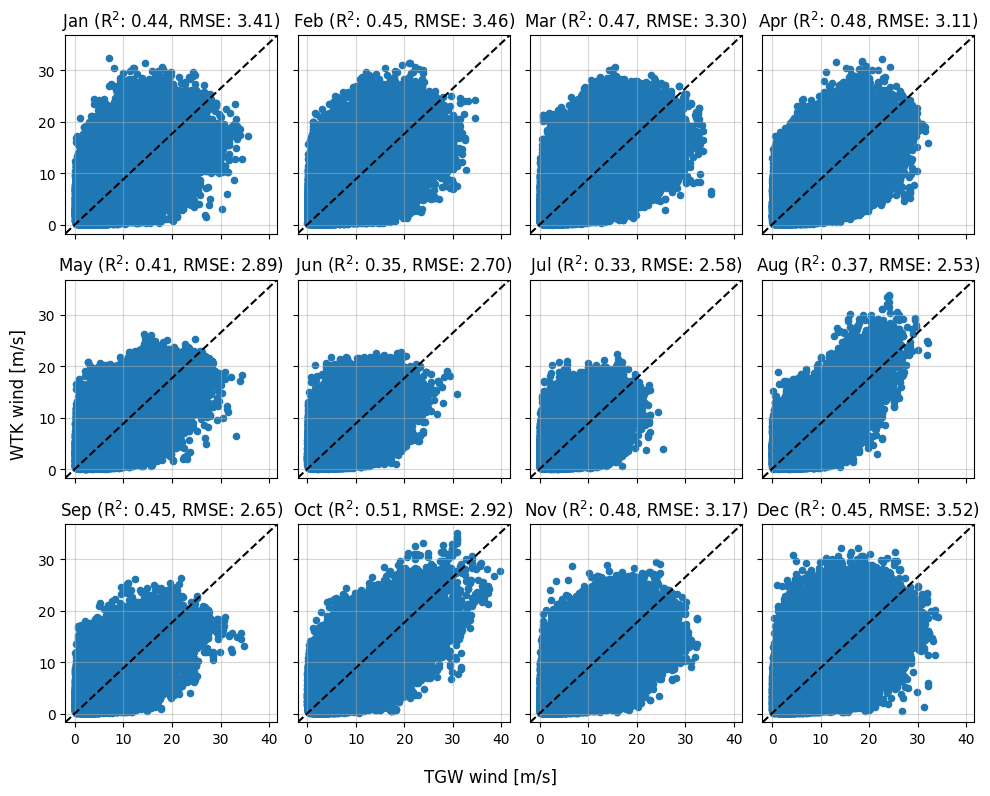

In [18]:
# Plot the fit results
fig, axs = plt.subplots(3, 4, figsize=(10,8), layout='tight', sharey=True, sharex=True)
axs = axs.flatten()

for month in range(1,13):
    ax = axs[month-1]
    df_tmp = df[df['month'] == month]
    
    df_tmp.plot.scatter(x='ws_corrected', y='ws_wtk', legend=False, ax=ax)

    # Add fit info
    r2 = (np.corrcoef(df_tmp.dropna()['ws_corrected'], df_tmp.dropna()['ws_wtk'])[0, 1]** 2)
    rmse = np.sqrt(np.mean((df_tmp.dropna()['ws_corrected'] - df_tmp.dropna()['ws_wtk']) ** 2))
    # Add 1:1 line
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="black")

    ax.set_title(f"{pu.month_names[month-1]} (R$^2$: {r2:.2f}, RMSE: {rmse:.2f})")
    ax.grid(alpha=0.5)
    ax.set_xlabel("")
    ax.set_ylabel("")

fig.supylabel('WTK wind [m/s]')
fig.supxlabel('TGW wind [m/s]')

plt.savefig('../../figs/wind_fit.png', dpi=300, bbox_inches='tight')

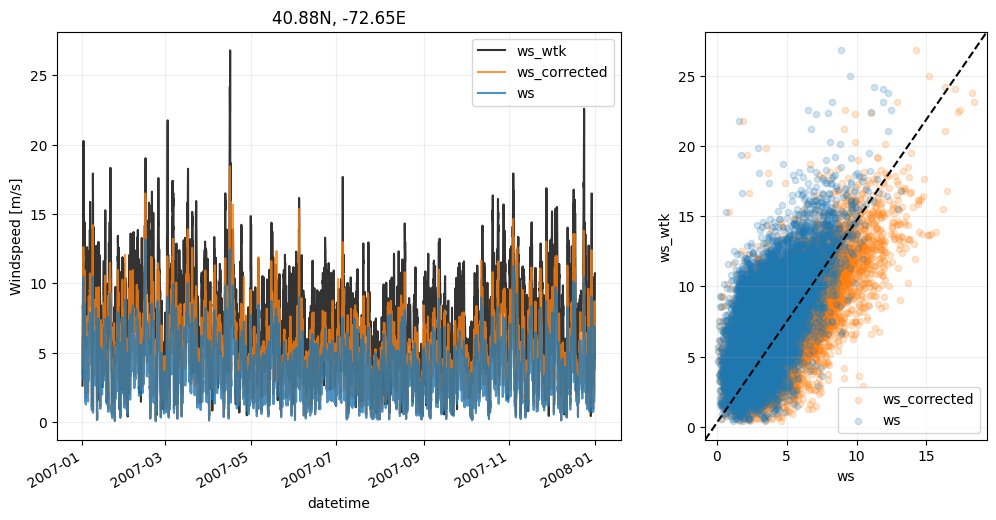

In [19]:
# Plot example timeseries
lat, lon = latlons[5]
year = 2007

df_sel = df[(df['wtk_lat'] == lat) & (df['wtk_lon'] == lon) & (df['datetime'].dt.year == year)]

fig, axs = plt.subplots(1, 2, figsize=(12,6), width_ratios=[5,2.5])

# Timeseries
ax = axs[0]
df_sel.plot(x='datetime', y='ws_wtk', alpha=0.8, ax=ax, color='black')
df_sel.plot(x='datetime', y='ws_corrected', alpha=0.8, ax=ax, color='C1')
df_sel.plot(x='datetime', y='ws', alpha=0.8, ax=ax, color='C0')
ax.set_ylabel('Windspeed [m/s]')
ax.set_title(f"{lat:.2f}N, {lon:.2f}E")
ax.grid(alpha=0.2)

# Scatter
ax = axs[1]
df_sel.plot.scatter(x='ws_corrected', y='ws_wtk', alpha=0.2, ax=ax, color='C1', label='ws_corrected')
df_sel.plot.scatter(x='ws', y='ws_wtk', alpha=0.2, ax=ax, color='C0', label='ws')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="black")
ax.legend()
ax.grid(alpha=0.2)

plt.savefig('../../figs/wind_example.png', dpi=300, bbox_inches='tight')

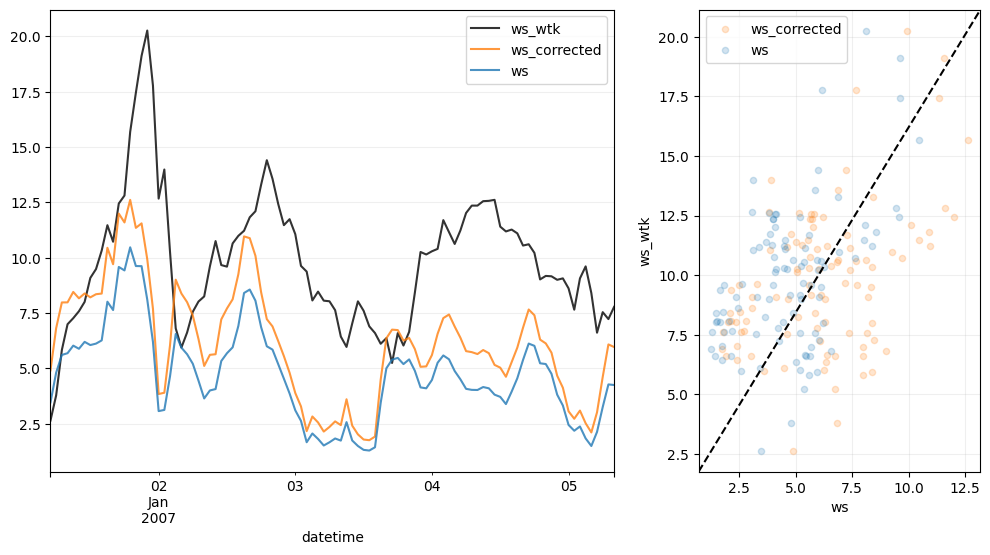

In [20]:
# Plot example timeseries
lat, lon = latlons[5]
year = 2007

df_sel = df[(df['wtk_lat'] == lat) & (df['wtk_lon'] == lon) & (df['datetime'].dt.year == year)][0:100]

fig, axs = plt.subplots(1, 2, figsize=(12,6), width_ratios=[5,2.5])

# Timeseries
ax = axs[0]
df_sel.plot(x='datetime', y='ws_wtk', alpha=0.8, ax=ax, color='black')
df_sel.plot(x='datetime', y='ws_corrected', alpha=0.8, ax=ax, color='C1')
df_sel.plot(x='datetime', y='ws', alpha=0.8, ax=ax, color='C0')

ax.grid(alpha=0.2)

# Scatter
ax = axs[1]
df_sel.plot.scatter(x='ws_corrected', y='ws_wtk', alpha=0.2, ax=ax, color='C1', label='ws_corrected')
df_sel.plot.scatter(x='ws', y='ws_wtk', alpha=0.2, ax=ax, color='C0', label='ws')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", color="black")
ax.legend()
ax.grid(alpha=0.2)

plt.show()

## Generating new timeseries

In [7]:
# Test data from genX output
df_genX = pd.read_csv(f'{pu.project_path}/data/genX/selected_CPA_Combined_Capacity_Low_RE_High_Elec.csv')

# Select wind in NYS, single result
df_genX_sel = df_genX[(df_genX["iter"] == 1) & (df_genX["state"] == "New York") & (df_genX["Resource_Type"] == "Onshore_Wind")].drop_duplicates(subset=["Resource", "Zone"])
df_genX_sel['region'] = df_genX_sel['region'].apply(lambda x: x.split("_")[-1])

In [8]:
# Mapping from genX zones -> full NYISO
genX_to_NYSIO_zones_random = {
    'A': lambda x: 'A',
    'B': lambda x: 'B',
    'D': lambda x: 'D',
    'F': lambda x: 'F',
    'K': lambda x: 'K',
    'C&E': lambda x: random.choice(['C', 'E']),
    'G-I': lambda x: random.choice(['G', 'H', 'I', 'J'])
}

genX_to_NYSIO_zones_sel = {
    'A': lambda x: 'A',
    'B': lambda x: 'B',
    'D': lambda x: 'D',
    'F': lambda x: 'F',
    'K': lambda x: 'K',
    'C&E': lambda x: 'E',
    'G-I': lambda x: 'G'
}

In [9]:
# Update the genX regions
df_genX_sel['genX_zone'] = df_genX_sel['region'].apply(lambda x: genX_to_NYSIO_zones_sel[x](x))

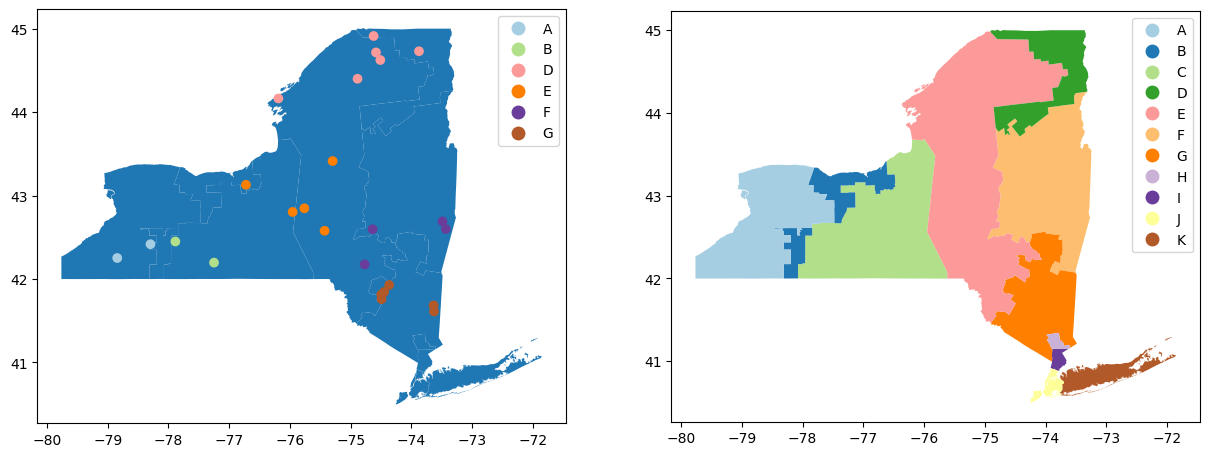

In [10]:
#######################################################
# NOTE: The genX zones do not align with my shapefile.
# When aggregating to bus level, assigning `match_zone` = True
# means that genX zones will be respected. `match_zone` = False
# means it will use the lat/lon coords instead.
#######################################################
# Read NYISO shapefile
nyiso_gdf = gpd.read_file(f'{pu.project_path}/data/nyiso/shapefiles/NYISO_Load_Zone_Dissolved.shp')

# Plot
fig, axs = plt.subplots(1,2, figsize=(15,10))

nyiso_gdf.plot(ax=axs[0])
pu.merge_to_zones(df_genX_sel, lat_name='latitude', lon_name='longitude').plot(ax=axs[0], column='genX_zone', legend=True, cmap='Paired')

nyiso_gdf.plot(ax=axs[1], column='ZONE', legend=True, cmap='Paired')

plt.show()

In [6]:
%%time
# TGW climate paths
climate_paths = np.array([glob(f"{pu.tgw_path}/historical_1980_2019/hourly/tgw_wrf_historical_hourly_{year}*.nc") 
                          for year in range(1980, 1985)]).flatten()

# Stability coefficients
stab_coef_file = f"{pu.project_path}/data/models/tgw_wind_stability_coefficients.csv"

# Calculate the timeseries
df_wind = wu.calculate_wind_timeseries_from_genX(
    df_genX = df_genX_sel,
    climate_paths = climate_paths,
    stab_coef_file = stab_coef_file,
    iec_curve = 'iec1',
)

CPU times: user 22.4 s, sys: 23.2 s, total: 45.6 s
Wall time: 1min 48s


<Axes: xlabel='datetime'>

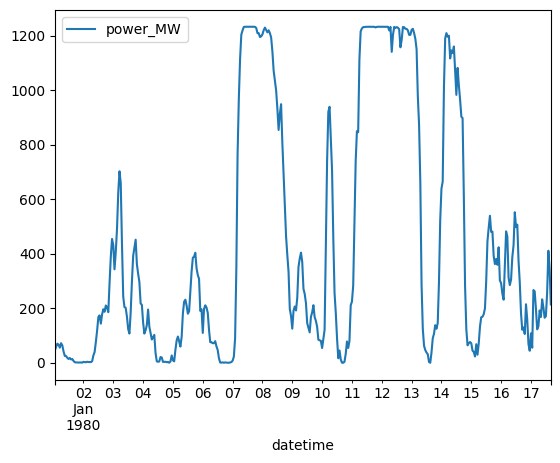

In [12]:
df_wind.loc[40][:400].plot()